<a href="https://colab.research.google.com/github/Milonahmed96/Credit-Risk-AI/blob/main/notebooks/Banking_Grade_Loan_Default_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup & Data Acquisition
In this phase, we import our libraries, set a premium visual style for our charts, and fetch the dataset.

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Premium visualization technique
plt.rcParams.update({
    'font.family': 'sans-serif',
    'axes.titlesize': 16,
    'axes.titleweight': 'bold',
    'axes.titlepad': 15,
    'axes.labelsize': 13,
    'axes.labelweight': 'bold',
    'axes.labelpad': 10,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 12,
    'legend.title_fontsize': 13,
    'figure.dpi': 120
})

sns.set_style("whitegrid", {"axes.edgecolor": ".8", "grid.color": ".9", "grid.linestyle": "--"})

# Corporate Risk Palette: Good/Safe = Blue-Green, Bad/Default = Crimson Red
BANKING_PALETTE = ["#20B2AA", "#DC143C"]
sns.set_palette(BANKING_PALETTE)

# DATA LOADING
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls'
print("Fetching banking dataset from UCI...")
df = pd.read_excel(url, header=1)

# Standardize columns / Coulmn Lowercase
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
df.rename(columns={'default_payment_next_month': 'default'}, inplace=True)
df.drop('id', axis=1, inplace=True)

print(f"{df.shape[0]} rows, {df.shape[1]} columns.")

Fetching banking dataset from UCI...
30000 rows, 24 columns.


In [2]:
df.head()

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Target Imbalance & Data Cleaning
We must establish our baseline default rate to justify our evaluation metrics later. We also clean undocumented demographic values (like `0, 5, 6` in Education) by mapping them to the "Others" category to prevent the model from learning noise.

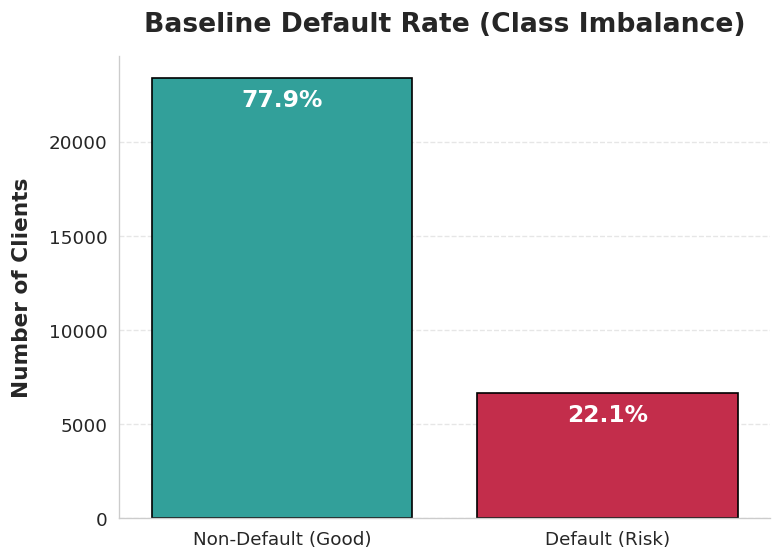

In [3]:
# Data Cleaning
df['education'] = df['education'].replace([0, 5, 6], 4)
df['marriage'] = df['marriage'].replace(0, 3)

# Visualizing the Class Imbalance
plt.figure(figsize=(7, 5))
ax = sns.countplot(data=df, x='default', palette=BANKING_PALETTE, edgecolor='black', linewidth=1)

# Formatting the plot
plt.title('Baseline Default Rate (Class Imbalance)')
plt.xticks([0, 1], ['Non-Default (Good)', 'Default (Risk)'])
plt.ylabel('Number of Clients')
plt.xlabel('')

# Adding clean percentage labels inside the bars
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() - 1500 # Position slightly below the top
    ax.text(x, y, percentage, ha='center', color='white', fontweight='bold', fontsize=14)

sns.despine()
plt.show()

# Credit-Risk Driven EDA
We explore the relationship between financial capacity (Credit Limit) and historical delinquency (Repayment Status) to find the business drivers of default.

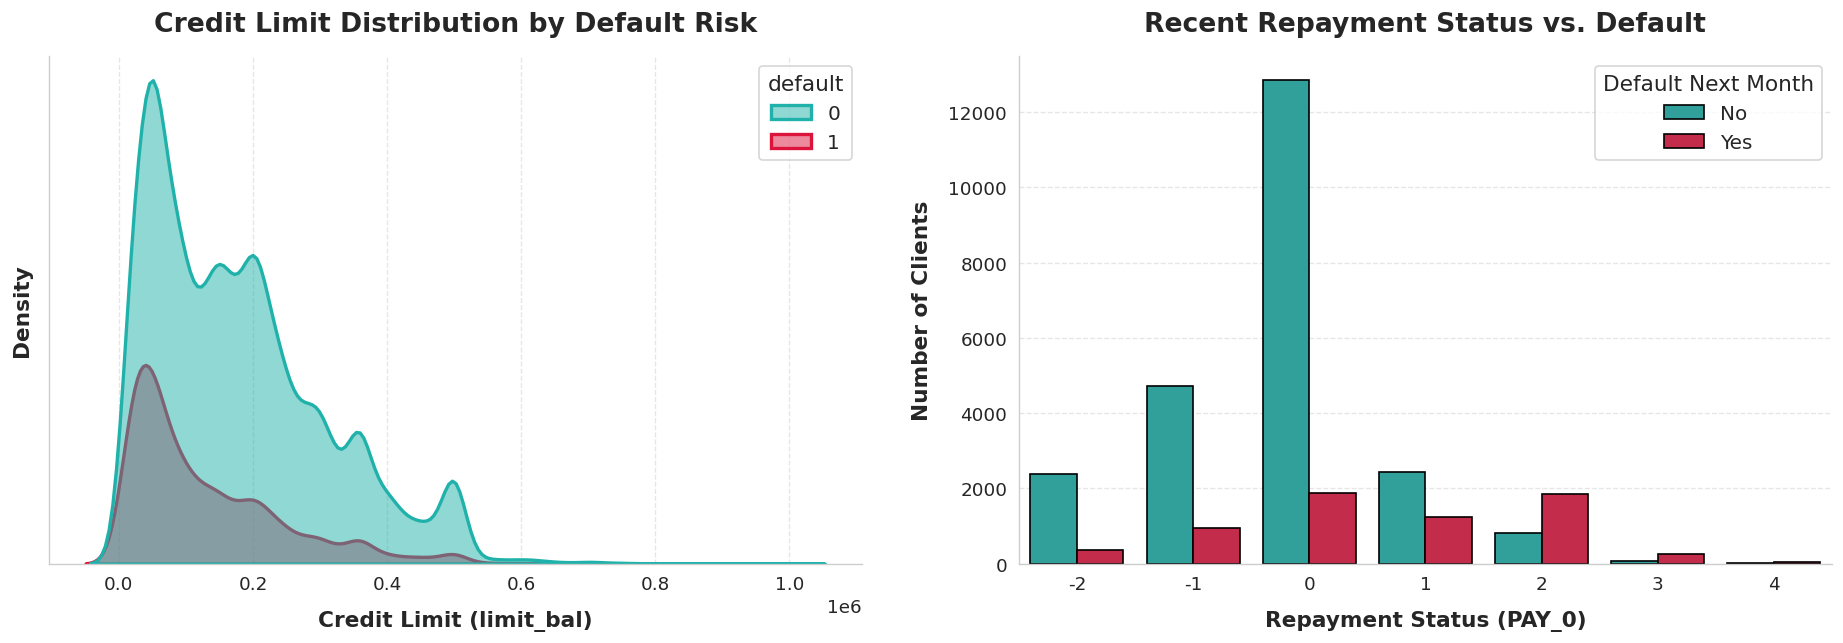

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Credit Limit Density
sns.kdeplot(data=df, x='limit_bal', hue='default', fill=True, alpha=0.5, linewidth=2,
            palette=BANKING_PALETTE, ax=axes[0])
axes[0].set_title('Credit Limit Distribution by Default Risk')
axes[0].set_xlabel('Credit Limit (limit_bal)')
axes[0].set_ylabel('Density')
axes[0].get_yaxis().set_ticks([])

# Plot 2: Recent Payment Status
# Filter out extreme outliers for a cleaner view (focus on -2 to 4 months late)
plot_df = df[df['pay_0'].between(-2, 4)]
sns.countplot(data=plot_df, x='pay_0', hue='default', palette=BANKING_PALETTE,
              edgecolor='black', ax=axes[1])
axes[1].set_title('Recent Repayment Status vs. Default')
axes[1].set_xlabel('Repayment Status (PAY_0)')
axes[1].set_ylabel('Number of Clients')
axes[1].legend(title='Default Next Month', labels=['No', 'Yes'], loc='upper right')

sns.despine()
plt.tight_layout(pad=3.0)
plt.show()

# Banking Feature Engineering & Preprocessing
We engineer high-value banking metrics to give the raw data business context:
1. `utilization_ratio`: Exhaustion of credit limit.
2. `pay_to_bill_ratio`: Identifies "transactors" vs. "revolvers".
3. `avg_payment_delay`: Smooths historical delinquency.
4. `bill_trend`: Captures the velocity of debt.

Finally, we process the data strictly preventing data leakage by splitting before scaling, and save it for modeling.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Advanced Feature Engineering
df['utilization_ratio'] = (df['bill_amt1'] / df['limit_bal']).clip(lower=0)
df['pay_to_bill_ratio'] = np.where(df['bill_amt1'] > 0, df['pay_amt1'] / df['bill_amt1'], 1.0)
df['pay_to_bill_ratio'] = np.clip(df['pay_to_bill_ratio'], 0, 1)

pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
df['avg_payment_delay'] = df[pay_cols].clip(lower=0).mean(axis=1)
df['bill_trend'] = df['bill_amt1'] - df['bill_amt6']

# Preprocessing & Encoding
categorical_cols = ['sex', 'education', 'marriage']
continuous_cols = ['limit_bal', 'age', 'utilization_ratio', 'pay_to_bill_ratio', 'avg_payment_delay', 'bill_trend'] + \
                  [f'bill_amt{i}' for i in range(1, 7)] + [f'pay_amt{i}' for i in range(1, 7)]

# One-Hot Encoding
df_processed = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

X = df_processed.drop('default', axis=1)
y = df_processed['default']

# Stratified Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
X_test_scaled[continuous_cols] = scaler.transform(X_test[continuous_cols])

# Save Processed Data for Notebook 2
train_data = pd.concat([X_train_scaled, y_train], axis=1)
test_data = pd.concat([X_test_scaled, y_test], axis=1)

train_data.to_csv('train_processed.csv', index=False)
test_data.to_csv('test_processed.csv', index=False)

print(f"{X_train_scaled.shape[1]}")

30


## Baseline Model Training
In this notebook, we load the engineered dataset and train a baseline Logistic Regression model. We use class weights to handle the 22% default rate imbalance, ensuring the model is penalized appropriately for missing potential defaulters.

In [6]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix

warnings.filterwarnings('ignore')

# Set consistent visualization parameters
plt.rcParams.update({
    'font.family': 'sans-serif',
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.dpi': 120
})
sns.set_style("whitegrid")
banking_palette = ["#20B2AA", "#DC143C"]
sns.set_palette(banking_palette)

# Load processed datasets
train_data = pd.read_csv('train_processed.csv')
test_data = pd.read_csv('test_processed.csv')

X_train = train_data.drop('default', axis=1)
y_train = train_data['default']
X_test = test_data.drop('default', axis=1)
y_test = test_data['default']

# Train Logistic Regression
log_reg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

# Generate probability predictions for threshold tuning
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]
y_pred_default = (y_pred_prob >= 0.5).astype(int)

## Model Evaluation
Because of the class imbalance, standard accuracy is misleading. We evaluate the model using ROC-AUC and PR-AUC, prioritizing the precision and recall of the default class.

In [7]:
roc_auc = roc_auc_score(y_test, y_pred_prob)
pr_auc = average_precision_score(y_test, y_pred_prob)

print("Evaluation Metrics (Threshold = 0.50)")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"PR-AUC Score:  {pr_auc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred_default, target_names=['Non-Default (0)', 'Default (1)']))

Evaluation Metrics (Threshold = 0.50)
ROC-AUC Score: 0.7490
PR-AUC Score:  0.5076

Classification Report:
                 precision    recall  f1-score   support

Non-Default (0)       0.87      0.82      0.85      4673
    Default (1)       0.48      0.57      0.52      1327

       accuracy                           0.77      6000
      macro avg       0.67      0.70      0.68      6000
   weighted avg       0.78      0.77      0.77      6000



# Cost-Aware Decision Threshold Tuning
The cost of approving a loan that defaults (False Negative) is significantly higher than rejecting a good customer (False Positive). We simulate a business cost matrix to identify the probability threshold that minimizes total portfolio loss.

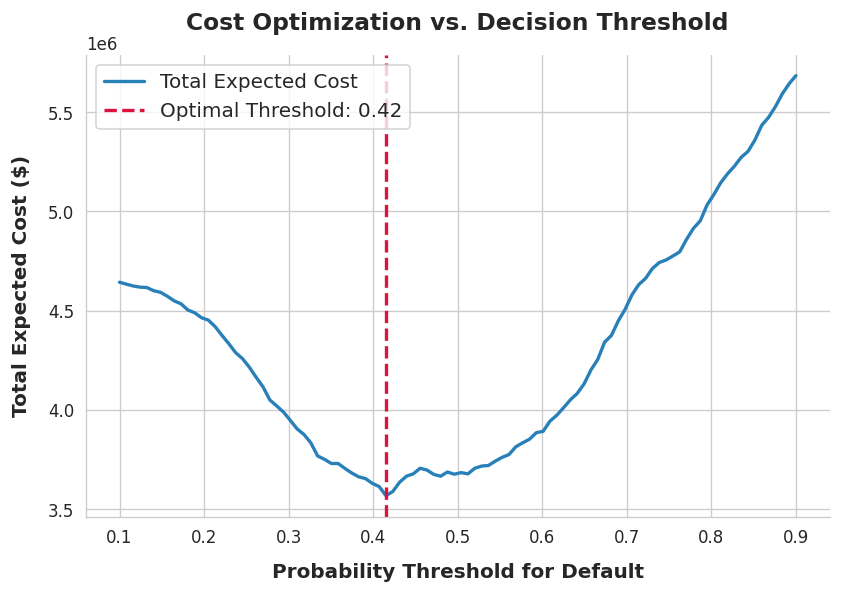

Optimal decision threshold identified at: 0.42


In [8]:
# Define business costs
cost_fn = 5000
cost_fp = 1000

thresholds = np.linspace(0.1, 0.9, 100)
costs = []

for t in thresholds:
    y_pred_t = (y_pred_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    total_cost = (fn * cost_fn) + (fp * cost_fp)
    costs.append(total_cost)

optimal_idx = np.argmin(costs)
optimal_threshold = thresholds[optimal_idx]
min_cost = costs[optimal_idx]

# Visualize the Cost Curve
plt.figure(figsize=(8, 5))
plt.plot(thresholds, costs, lw=2, color='#2980B9', label='Total Expected Cost')
plt.axvline(optimal_threshold, color='#DC143C', linestyle='--', lw=2,
            label=f'Optimal Threshold: {optimal_threshold:.2f}')

plt.title('Cost Optimization vs. Decision Threshold')
plt.xlabel('Probability Threshold for Default')
plt.ylabel('Total Expected Cost ($)')
plt.legend()
sns.despine()
plt.show()

print(f"Optimal decision threshold identified at: {optimal_threshold:.2f}")

# Model Explainability
To satisfy regulatory requirements and build trust with business stakeholders, we extract the logistic regression coefficients to interpret the drivers of default risk.

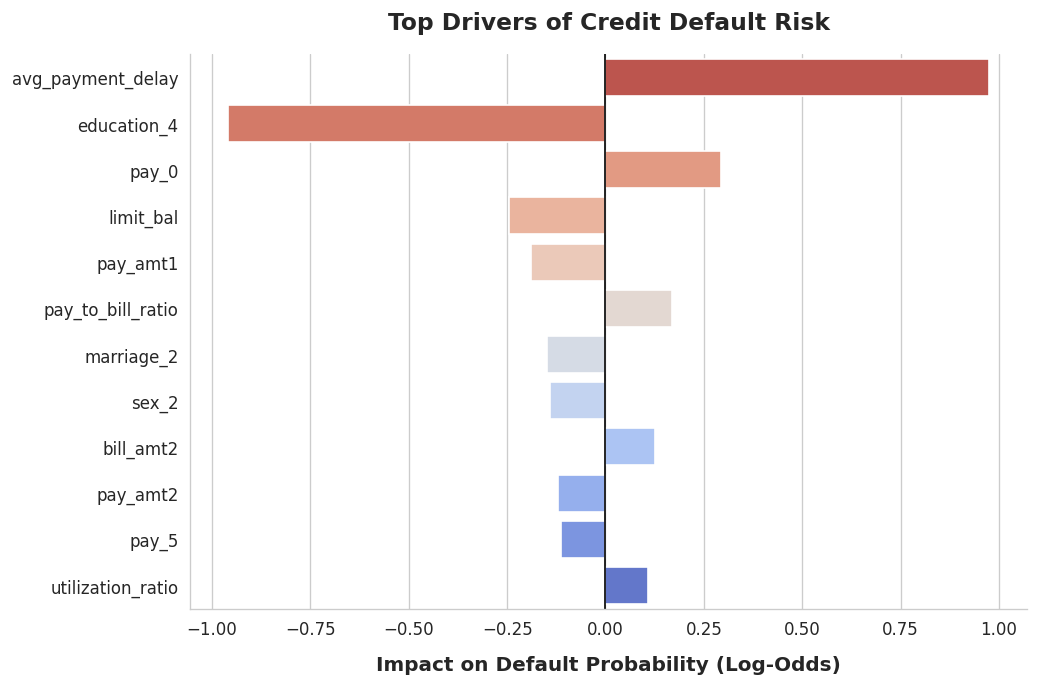

In [9]:
coefficients = log_reg.coef_[0]
feature_names = X_train.columns

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(12)

# Visualize Feature Importance
plt.figure(figsize=(9, 6))
sns.barplot(data=top_features, x='Coefficient', y='Feature', palette="coolwarm_r")

plt.title('Top Drivers of Credit Default Risk')
plt.xlabel('Impact on Default Probability (Log-Odds)')
plt.ylabel('')
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)

sns.despine()
plt.show()

#  Advanced Modeling (XGBoost)
While Logistic Regression provides a strong, interpretable baseline, credit behavior often contains non-linear relationships (e.g., the compounding risk of high utilization combined with late payments). In this phase, we train an XGBoost classifier to capture these complex interactions.

We address the class imbalance using the `scale_pos_weight` parameter, which is the gradient boosting equivalent of class weights.

In [10]:
# Install shap if not already installed in the environment
!pip -q install shap xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
import shap
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

warnings.filterwarnings('ignore')

# Set consistent visualization parameters
plt.rcParams.update({
    'font.family': 'sans-serif',
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.dpi': 120
})
sns.set_style("whitegrid")

# Load processed datasets
train_data = pd.read_csv('train_processed.csv')
test_data = pd.read_csv('test_processed.csv')

X_train = train_data.drop('default', axis=1)
y_train = train_data['default']
X_test = test_data.drop('default', axis=1)
y_test = test_data['default']

# Calculate ratio of negative to positive class for scale_pos_weight
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

# Initialize and train XGBoost
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=class_ratio,
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

XGBoost model training complete.


# Advanced Model Evaluation
We evaluate the XGBoost model using the same banking-specific metrics applied to the baseline model (ROC-AUC and PR-AUC) to determine if the non-linear algorithm provides a measurable lift in distinguishing default risk.

In [11]:
# Generate probability predictions
y_pred_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_pred_default_xgb = (y_pred_prob_xgb >= 0.5).astype(int)

roc_auc_xgb = roc_auc_score(y_test, y_pred_prob_xgb)
pr_auc_xgb = average_precision_score(y_test, y_pred_prob_xgb)

print("XGBoost Evaluation Metrics (Threshold = 0.50)")
print(f"ROC-AUC Score: {roc_auc_xgb:.4f}")
print(f"PR-AUC Score:  {pr_auc_xgb:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred_default_xgb, target_names=['Non-Default (0)', 'Default (1)']))

XGBoost Evaluation Metrics (Threshold = 0.50)
ROC-AUC Score: 0.7803
PR-AUC Score:  0.5561

Classification Report:
                 precision    recall  f1-score   support

Non-Default (0)       0.88      0.78      0.83      4673
    Default (1)       0.45      0.63      0.53      1327

       accuracy                           0.75      6000
      macro avg       0.67      0.71      0.68      6000
   weighted avg       0.79      0.75      0.76      6000



# Global Explainability via SHAP
Gradient boosting models are historically viewed as "black boxes," which is unacceptable in regulatory finance. We utilize SHAP (SHapley Additive exPlanations) to decompose the model's predictions. The SHAP summary plot illustrates both feature importance (y-axis) and the directional impact of feature values on the default probability (color and x-axis).

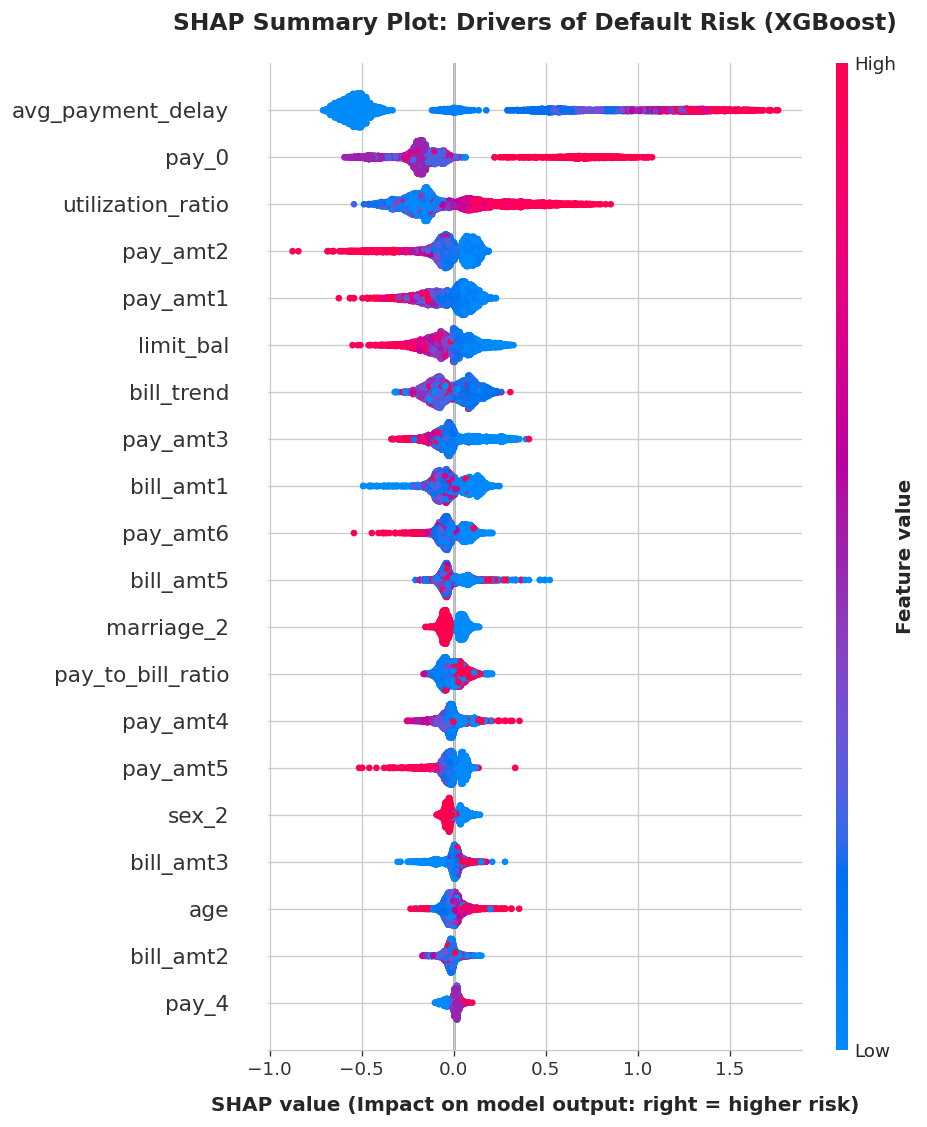

In [12]:
# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for the test set
# Using a sample if the test set is exceptionally large to save computation time,
# but 6,000 rows (20% of 30k) processes quickly enough.
shap_values = explainer.shap_values(X_test)

# Visualize SHAP Summary Plot
plt.figure(figsize=(10, 8))
plt.title("SHAP Summary Plot: Drivers of Default Risk (XGBoost)", fontweight='bold', fontsize=14, pad=20)
shap.summary_plot(shap_values, X_test, show=False)

# Adjust plot aesthetics to match the project theme
fig = plt.gcf()
fig.set_dpi(120)
plt.xlabel("SHAP value (Impact on model output: right = higher risk)", fontsize=12, fontweight='bold')
plt.show()